# used Libraries 

-- date time --> use in the main and date_chcker module to modify and validating start date and end date as argument of yf.Dowanload() to creat data set
-- sys --> Handel errors and code intruptions
-- typing --> define vraiables to improve code following 
-- pandas --> to work with data frames fetch by yfinance
-- numpy --> using math tools such as prodact of matrix and vector or transposing vector especialy in portfolio mode
-- yfinance --> fetche data for desire stocks such as Adjacet close price or valid date 
-- matplotlib .pyplot --> visualising the results 
-- IPython.display --> display data frame in output

In [ ]:
# ==============================================================================
# 📚 1. Standard Library Imports
# ==============================================================================
from datetime import date, datetime
import sys
from typing import List, Set, Tuple

# ==============================================================================
# 📚 2. Third-Party Library Imports
# ==============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display

# ==============================================================================
# 📚 3. Helper Module Imports
# ==============================================================================
try:
    from input_number_symbols import get_integer_input, get_valid_symbols
    from date_checker import get_min_valid_date, get_valid_date_input
    from interval import set_interval
except ImportError as e:
    print(f"⚠️ Critical Import Error: {e}")
    print(
        "Please ensure 'input_number_symbols.py', 'date_checker.py', and 'interval.py' are in the directory."
    )
    sys.exit()

# ==============================================================================
# ⚙️ 4. Global Constants (Risk-Free Rate)
# ==============================================================================
RISK_FREE_RATE_PERCENT = 4.25  # e.g., 4.25
RISK_FREE_RATE_DECIMAL = 4.25 / 100.0  # e.g., 0.0425


# ==============================================================================
# 🧮 5. Calculation Functions
# ==============================================================================


def calculate_rolling_metrics_optimized(
    df: pd.DataFrame, time_frame: int, time_step: int, coefficient: int
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Calculates rolling Mean, Volatility, and Sharpe Ratio (Script 1 Logic)."""
    if time_frame > len(df):
        raise ValueError("Time frame is larger than the total number of data points.")

    df_simple_returns = df.pct_change() * 100
    df_simple_returns = df_simple_returns.dropna()

    df_rolling_mean = df_simple_returns.rolling(window=time_frame).mean()
    df_rolling_vol = df_simple_returns.rolling(window=time_frame).std()

    Rf_per_period = (1 + RISK_FREE_RATE_PERCENT / 100) ** (1 / coefficient) - 1
    Rf_per_period_perc = Rf_per_period * 100

    df_rolling_sharpe = (
        (df_rolling_mean - Rf_per_period_perc) / df_rolling_vol * np.sqrt(coefficient)
    )

    start_index = time_frame - 1
    df_mean_stepped = df_rolling_mean.iloc[start_index::time_step].dropna(how="all")
    df_vol_stepped = df_rolling_vol.iloc[start_index::time_step].dropna(how="all")
    df_sharpe_stepped = df_rolling_sharpe.iloc[start_index::time_step].dropna(how="all")

    return (df_mean_stepped, df_vol_stepped, df_sharpe_stepped)


def calculate_sharpe_ratio(
    weights,
    mean_returns_decimal,
    cov_matrix_decimal,
    risk_free_rate_annual,
    coefficient,
):
    """Calculates the annualized Sharpe Ratio (Script 2 Logic)."""
    annual_return = np.sum(mean_returns_decimal * weights) * coefficient
    annual_volatility = np.sqrt(
        np.dot(weights.T, np.dot(cov_matrix_decimal, weights))
    ) * np.sqrt(coefficient)

    if annual_volatility == 0:
        return 0.0

    sharpe_ratio = (annual_return - risk_free_rate_annual) / annual_volatility
    return sharpe_ratio


def negative_sharpe_ratio(
    weights,
    mean_returns_decimal,
    cov_matrix_decimal,
    risk_free_rate_annual,
    coefficient,
):
    """Objective function for minimization."""
    if not np.isclose(np.sum(weights), 1.0):
        pass
    sharpe = calculate_sharpe_ratio(
        weights,
        mean_returns_decimal,
        cov_matrix_decimal,
        risk_free_rate_annual,
        coefficient,
    )
    return -sharpe


# ==============================================================================
# 📈 6. Visualization Function
# ==============================================================================


def plot_metrics(
    df: pd.DataFrame,
    title: str,
    is_rolling: bool,
    kind: str = "line",
    time_frame: int = None,
    time_step: int = None,
    value_label: str = None,
):
    try:
        plt.figure(figsize=(12, 6))
        full_title = title
        x_label = "Date"
        color = None

        if is_rolling:
            full_title += f"\n(Window Size: {time_frame}, Step: {time_step})"
            x_label = "End Date of Rolling Window"

        if kind == "bar":
            if "Volatility" in title:
                color = "red"
            elif "Sharpe" in title:
                color = "blue"
            elif "Mean" in title:
                color = "green"

            ax = df.plot(
                kind="bar",
                figsize=(12, 6),
                color=color,
                alpha=0.8,
                edgecolor="black",
                legend=False,
            )
            plt.axhline(0, color="black", linewidth=0.8)
            x_label = "Symbols"
            plt.xticks(rotation=0)

            for p in ax.patches:
                ax.annotate(
                    f"{p.get_height():.4f}",
                    (p.get_x() + p.get_width() / 2.0, p.get_height()),
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    color="black",
                    xytext=(0, 5),
                    textcoords="offset points",
                )
        else:
            plt.plot(df)
            x_label = "Date"

        y_label = value_label if value_label else "Value"

        plt.title(full_title, fontsize=16)
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel(y_label, fontsize=12)

        if kind == "line":
            plt.legend(
                df.columns, title="Symbols", bbox_to_anchor=(1.05, 1), loc="upper left"
            )

        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not generate plot for '{title}'. Error: {e}", file=sys.stderr)


# ==============================================================================
# 🏁 7. Main Execution Block
# ==============================================================================


def execute_analysis():
    print("=========================================")
    print("   🚀 FINANCIAL ANALYSIS TOOLKIT V1.0    ")
    print("=========================================\n")

    # ---------------------------------------------------------
    # PART A: SELECT MODE (Moved to the start)
    # ---------------------------------------------------------
    print("Please select your Analysis Mode:")
    print("[1] Individual Stock Analysis (Rolling Mean, Volatility, Sharpe)")
    print("[2] Portfolio Optimization (Weights, Covariance, Markowitz)")

    mode = input("Enter 1 or 2: ").strip()

    if mode not in ["1", "2"]:
        print("🛑 Invalid mode selection. Exiting.")
        sys.exit()

    # ---------------------------------------------------------
    # PART B: Input Collection & Data Download
    # ---------------------------------------------------------
    print("\n--- Data Configuration ---")
    N_stocks = get_integer_input("Please enter the number of stocks: ")

    # Validation hint for Portfolio Mode
    if mode == "2" and N_stocks < 2:
        print("⚠️ Note: Portfolio optimization typically requires 2 or more stocks.")

    Set_stocks: Set[str] = get_valid_symbols(N_stocks)

    if not Set_stocks:
        print("Execution aborted due to symbol entry error.")
        sys.exit()

    List_stocks: List[str] = list(Set_stocks)
    print(f"\n**Selected Stocks:** {List_stocks}\n")

    # Date Collection
    min_common_date = get_min_valid_date(Set_stocks)
    today_date = date.today()
    S_date = get_valid_date_input(
        f"Enter Start Date (YYYY-MM-DD, min: {min_common_date}): ",
        min_date=min_common_date,
        max_date=today_date,
    )
    S_date_dt = datetime.strptime(S_date, "%Y-%m-%d").date()
    E_date = get_valid_date_input(
        f"Enter End Date (YYYY-MM-DD, min: {S_date}): ",
        min_date=S_date_dt,
        max_date=today_date,
    )
    interval, coefficient = set_interval(S_date, E_date)
    print(f"\n**Data Range:** {S_date} to {E_date}, Interval: {interval}")

    # Data Download
    print("\n⬇️ Downloading data from Yahoo Finance...")
    try:
        data = yf.download(
            List_stocks, start=S_date, end=E_date, interval=interval, auto_adjust=False
        )
        if data.empty:
            raise ValueError("No data returned.")
    except Exception as e:
        print(f"🛑 Error during data download: {e}", file=sys.stderr)
        sys.exit()

    # Extract Adjusted Close
    DF_Adj_Close: pd.DataFrame = data["Adj Close"].copy()
    DF_Adj_Close.dropna(inplace=True)

    if DF_Adj_Close.empty or len(DF_Adj_Close) < 2:
        print("🛑 Insufficient valid data. Aborting.")
        sys.exit()

    # Initial Plot
    display(DF_Adj_Close.head())
    plot_metrics(
        DF_Adj_Close,
        "Adjusted Close Price Time Series",
        is_rolling=False,
        kind="line",
        value_label="Price (Dollars)",
    )

    # ---------------------------------------------------------
    # PART C: Execute Selected Mode Logic
    # ---------------------------------------------------------

    # ==============================================================================
    # MODE 1: Individual Stock Analysis
    # ==============================================================================
    if mode == "1":
        print("\n🔵 STARTING INDIVIDUAL STOCK ANALYSIS")

        DF_simple_return: pd.DataFrame = DF_Adj_Close.pct_change() * 100
        DF_simple_return = DF_simple_return.dropna()

        print("\n📊 Simple Returns (Sample):")
        display(DF_simple_return.head())

        option = (
            str(
                input(
                    "\nDo you want Full-Period results (Y) or Rolling Time Frame (N)? (Y/N): "
                )
            )
            .strip()
            .upper()
        )

        if option == "Y":
            # Full Period
            df_mean_full = DF_simple_return.mean().to_frame("Mean Return")
            df_vol_full = DF_simple_return.std().to_frame("Volatility")

            Rf_per_period = (1 + RISK_FREE_RATE_PERCENT / 100) ** (1 / coefficient) - 1
            Rf_per_period_perc = Rf_per_period * 100

            df_sharpe_full = (
                (df_mean_full["Mean Return"] - Rf_per_period_perc)
                / df_vol_full["Volatility"]
                * np.sqrt(coefficient)
            )
            df_sharpe_full = df_sharpe_full.to_frame("Sharpe Ratio")

            df_results = pd.concat([df_mean_full, df_vol_full, df_sharpe_full], axis=1)
            print("\n📊 Full Period Metrics:")
            display(df_results)

            plot_metrics(DF_simple_return, "Simple Return Time Series", False, "line")
            plot_metrics(df_vol_full, "Full Period Volatility Comparison", False, "bar")
            plot_metrics(
                df_sharpe_full, "Full Period Sharpe Ratio Comparison", False, "bar"
            )

        else:
            # Rolling Period
            print(f"\nGiven your data has **{len(DF_Adj_Close)}** periods.")
            time_frame = get_integer_input("Enter time_frame (window size, e.g., 20): ")
            time_step = get_integer_input(
                "Enter time_step (periods to step, e.g., 5): "
            )

            try:
                (df_mean_roll, df_vol_roll, df_sharpe_roll) = (
                    calculate_rolling_metrics_optimized(
                        DF_Adj_Close, time_frame, time_step, coefficient
                    )
                )
                print("\n💹 Generating plots for rolling metrics...")
                plot_metrics(
                    df_mean_roll,
                    "Rolling Simple Mean Return",
                    True,
                    "line",
                    time_frame,
                    time_step,
                    "Percent per period",
                )
                plot_metrics(
                    df_vol_roll,
                    "Rolling Volatility",
                    True,
                    "line",
                    time_frame,
                    time_step,
                    "Percent per period",
                )
                plot_metrics(
                    df_sharpe_roll,
                    "Rolling Sharpe Ratio",
                    True,
                    "line",
                    time_frame,
                    time_step,
                )

            except ValueError as e:
                print(f"\n🛑 Error in rolling calculation: {e}")
                sys.exit()

    # ==============================================================================
    # MODE 2: Portfolio Analysis
    # ==============================================================================
    elif mode == "2":
        print("\n🟣 STARTING PORTFOLIO OPTIMIZATION")

        # 1. Weights
        option = (
            input(
                "Do you want to enter a custom weight vector? (Y/N, default is N for equal weight): "
            )
            .strip()
            .upper()
        )

        total_amount_input = input(
            f"Enter the total amount to invest (default: 1000 euros): "
        )
        try:
            total_amount = float(total_amount_input)
        except ValueError:
            total_amount = 1000.0
            print(f"Invalid amount entered. Defaulting to {total_amount:.2f} euros.")

        weight = np.zeros(N_stocks)
        if option == "Y":
            print("\n**Entering Custom Weights** (Must be non-negative)")
            for i in range(N_stocks):
                while True:
                    weight_input = input(
                        f"Enter the weight of {List_stocks[i]} (e.g., 0.1): "
                    )
                    try:
                        w = float(weight_input)
                        if w < 0:
                            print("Weight must be non-negative.")
                            continue
                        weight[i] = w
                        break
                    except ValueError:
                        print("Invalid number. Try again.")
        else:
            weight = np.array([1.0 / N_stocks] * N_stocks)
            print("\n**Using Equal Weights.**")

        sum_weight = np.sum(weight)
        if sum_weight == 0:
            print("🛑 Total weight is zero. Aborting.")
            sys.exit()
        normal_w = weight / sum_weight
        print(f"Normalized weights: {dict(zip(List_stocks, normal_w))}")

        # 2. Portfolio Calculation
        DF_simple_return: pd.DataFrame = DF_Adj_Close.pct_change() * 100
        DF_simple_return = DF_simple_return.dropna()

        portfolio_daily_returns_perc: pd.Series = DF_simple_return.dot(normal_w)

        DF_Prt_value_daily = pd.DataFrame(
            index=portfolio_daily_returns_perc.index,
            columns=["The daily value of the portfolio"],
        )
        current_portfolio_value = total_amount
        for i in portfolio_daily_returns_perc.index:
            current_portfolio_value = current_portfolio_value * (
                1 + portfolio_daily_returns_perc.loc[i] / 100.0
            )
            DF_Prt_value_daily.loc[i] = current_portfolio_value

        print("\n💰 Daily Portfolio Value:")
        display(DF_Prt_value_daily.head())
        plot_metrics(
            DF_Prt_value_daily,
            "Portfolio Value Time Series",
            False,
            "line",
            value_label="Value (Currency)",
        )

        # 3. Metrics
        df_cov = DF_simple_return.cov()
        cov_matrix = df_cov.to_numpy()
        cov_matrix_decimal = cov_matrix / 10000.0  # Convert from %^2 to decimal^2

        volatility_annual_decimal = np.sqrt(
            np.dot(normal_w.T, np.dot(cov_matrix_decimal, normal_w))
        ) * np.sqrt(coefficient)
        volatility_annual_perc = volatility_annual_decimal * 100.0
        print(
            f"\n✨ Current Annualized Portfolio Volatility: {volatility_annual_perc:.4f}%"
        )

        mean_returns_decimal = DF_simple_return.mean() / 100.0
        portfolio_return_annual_decimal = (
            np.sum(mean_returns_decimal * normal_w) * coefficient
        )

        sharpe_ratio_full = (
            portfolio_return_annual_decimal - RISK_FREE_RATE_DECIMAL
        ) / volatility_annual_decimal

        df_sharpe_full = pd.DataFrame(
            {"Portfolio": sharpe_ratio_full}, index=["Sharpe Ratio"]
        ).T
        print("\n⭐ Full Period Portfolio Annualized Sharpe Ratio:")
        display(df_sharpe_full)
        plot_metrics(
            df_sharpe_full,
            "Current Portfolio Sharpe Ratio",
            False,
            "bar",
            value_label="Sharpe Ratio",
        )

        # 4. Optimization
        print("\n⚙️ Starting Markowitz Optimization (Maximize Sharpe Ratio)...")
        num_assets = len(List_stocks)
        bounds = tuple((0, 1) for _ in range(num_assets))
        constraints = {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}
        initial_weights = normal_w

        optimal_results = minimize(
            negative_sharpe_ratio,
            initial_weights,
            args=(
                mean_returns_decimal,
                cov_matrix_decimal,
                RISK_FREE_RATE_DECIMAL,
                coefficient,
            ),
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )

        if optimal_results.success:
            optimal_weights = optimal_results.x
            optimal_sharpe = -optimal_results.fun

            print("\n✅ Optimization Successful!")
            print(f"Optimal Annualized Sharpe Ratio: {optimal_sharpe:.4f}")
            print("\nOptimal Weights (Decimal):")
            optimal_weights_dict = dict(zip(List_stocks, optimal_weights))
            for symbol, weight in optimal_weights_dict.items():
                print(f"  {symbol}: {weight:.4f} ({weight*100:.2f}%)")

            optimal_return_annual = (
                np.sum(mean_returns_decimal * optimal_weights) * coefficient
            )
            optimal_volatility_annual = np.sqrt(
                np.dot(optimal_weights.T, np.dot(cov_matrix_decimal, optimal_weights))
            ) * np.sqrt(coefficient)

            print(f"\nOptimal Annualized Return: {optimal_return_annual*100:.4f}%")
            print(
                f"Optimal Annualized Volatility: {optimal_volatility_annual*100:.4f}%"
            )
        else:
            print(f"\n❌ Optimization Failed. Status: {optimal_results.message}")


if __name__ == "__main__":
    execute_analysis()


   🚀 FINANCIAL ANALYSIS TOOLKIT V1.0    

Please select your Analysis Mode:
[1] Individual Stock Analysis (Rolling Mean, Volatility, Sharpe)
[2] Portfolio Optimization (Weights, Covariance, Markowitz)

--- Data Configuration ---

🍪 Generating 10 random S&P 500 symbols...

**Selected Stocks:** ['JBL', 'PGR', 'CMS', 'ROL', 'GNRC', 'GWW', 'OMC', 'TRMB', 'MAS', 'MDT']


🔍 Checking minimum valid history date for all selected stocks...
   -> Lowest valid date for JBL is 1993-05-03
   -> Lowest valid date for PGR is 1980-03-17
   -> Lowest valid date for CMS is 1973-02-21
   -> Lowest valid date for ROL is 1980-03-17
   -> Lowest valid date for GNRC is 2010-02-11
   -> Lowest valid date for GWW is 1973-02-21
   -> Lowest valid date for OMC is 1980-03-17
   -> Lowest valid date for TRMB is 1990-07-20
   -> Lowest valid date for MAS is 1980-03-17
   -> Lowest valid date for MDT is 1973-05-02

✅ Given your symbol(s) list, the **minimum common valid start date** is: **2010-02-11**

📅 Given the se

[**********            20%                       ]  2 of 10 completed


**Data Range:** 2020-01-01 to 2025-01-01, Interval: 5d

⬇️ Downloading data from Yahoo Finance...


[*********************100%***********************]  10 of 10 completed


Ticker,CMS,GNRC,GWW,JBL,MAS,MDT,OMC,PGR,ROL,TRMB
Date,,,,,,,,,,
2020-01-06,52.292881,101.250000,313.634125,39.783005,42.928699,97.349388,64.544136,66.200737,20.603031,41.310001
2020-01-16,54.623867,103.919998,317.026184,41.911629,44.292068,100.713287,64.682106,68.114891,22.097263,43.930000
2020-01-21,55.317318,102.410004,310.809143,41.610317,44.672489,101.950363,65.144707,69.008736,22.252268,44.180000
2020-01-31,57.238930,103.589996,281.275543,37.800171,43.042118,97.815414,61.119316,72.855133,23.529491,42.520000
2020-02-05,56.737644,104.070000,292.789764,39.258137,45.197845,102.204559,63.115772,74.940826,24.168108,45.009998


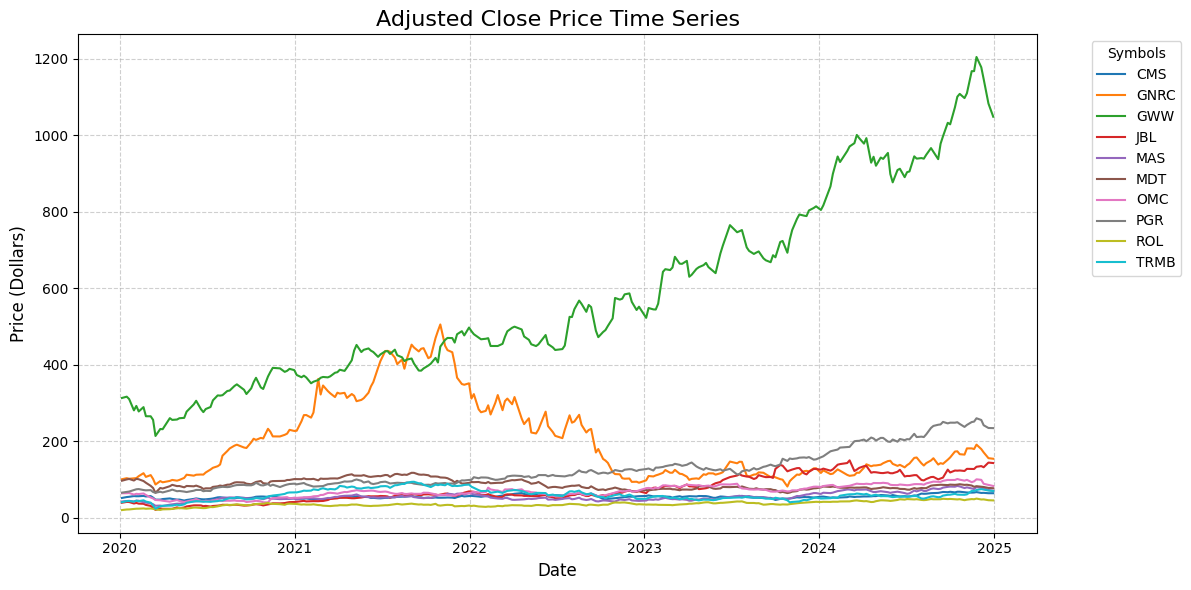


🔵 STARTING INDIVIDUAL STOCK ANALYSIS

📊 Simple Returns (Sample):


Ticker,CMS,GNRC,GWW,JBL,MAS,MDT,OMC,PGR,ROL,TRMB
Date,,,,,,,,,,
2020-01-16,4.457559,2.637035,1.081534,5.350586,3.175892,3.455491,0.213761,2.891439,7.252487,6.342287
2020-01-21,1.269502,-1.453036,-1.961050,-0.718921,0.858891,1.228314,0.715191,1.312260,0.701465,0.569087
2020-01-31,3.473798,1.152224,-9.502166,-9.156735,-3.649609,-4.055845,-6.179152,5.573783,5.739746,-3.757356
2020-02-05,-0.875777,0.463368,4.093574,3.857035,5.008414,4.487171,3.266490,2.862795,2.714111,5.856063
2020-02-10,0.085912,5.025467,-4.919193,-4.654608,-0.501015,-1.028034,-0.990075,0.710847,0.280300,-2.621632



📊 Full Period Metrics:


,Mean Return,Volatility,Sharpe Ratio
Ticker,,,
CMS,0.127083,2.862204,0.118437
GNRC,0.426555,7.118327,0.350997
GWW,0.559450,3.747274,0.922493
JBL,0.665321,5.377628,0.784784
MAS,0.277761,3.828515,0.372348
MDT,-0.032167,3.431642,-0.235858
OMC,0.179843,3.912596,0.183880
PGR,0.564007,3.178432,1.097930
ROL,0.387100,3.553273,0.623087


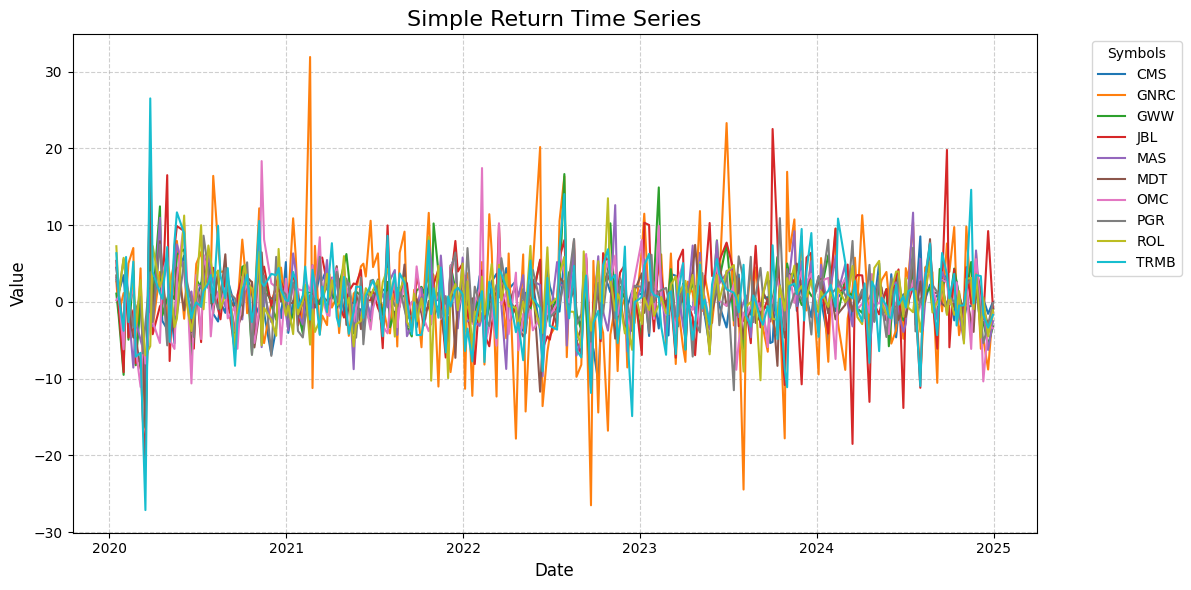

<Figure size 1200x600 with 0 Axes>

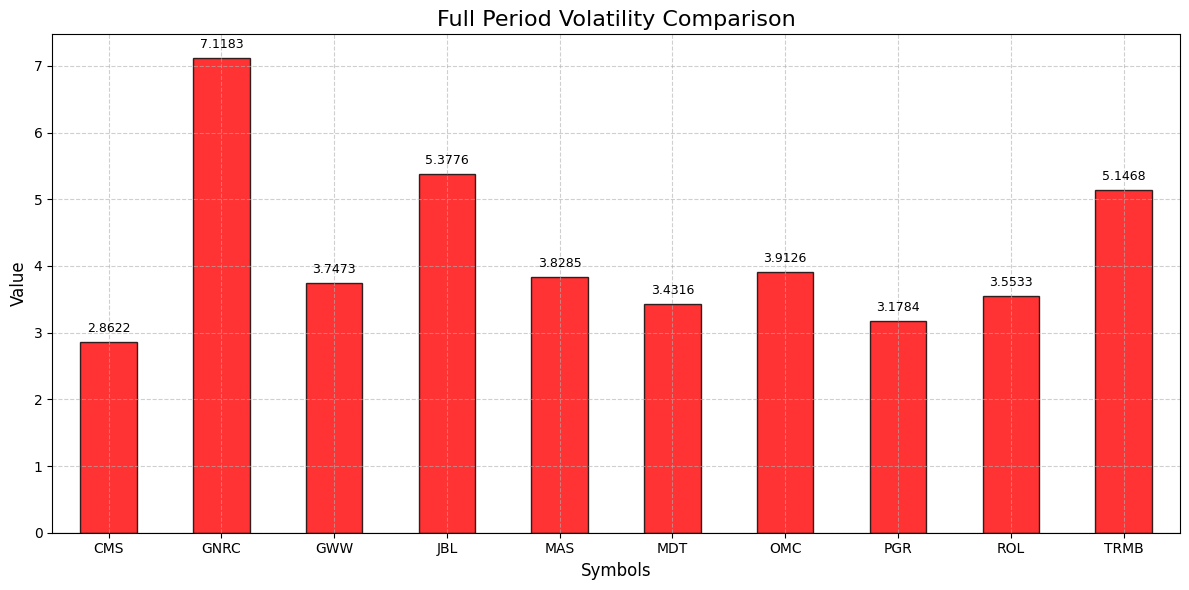

<Figure size 1200x600 with 0 Axes>

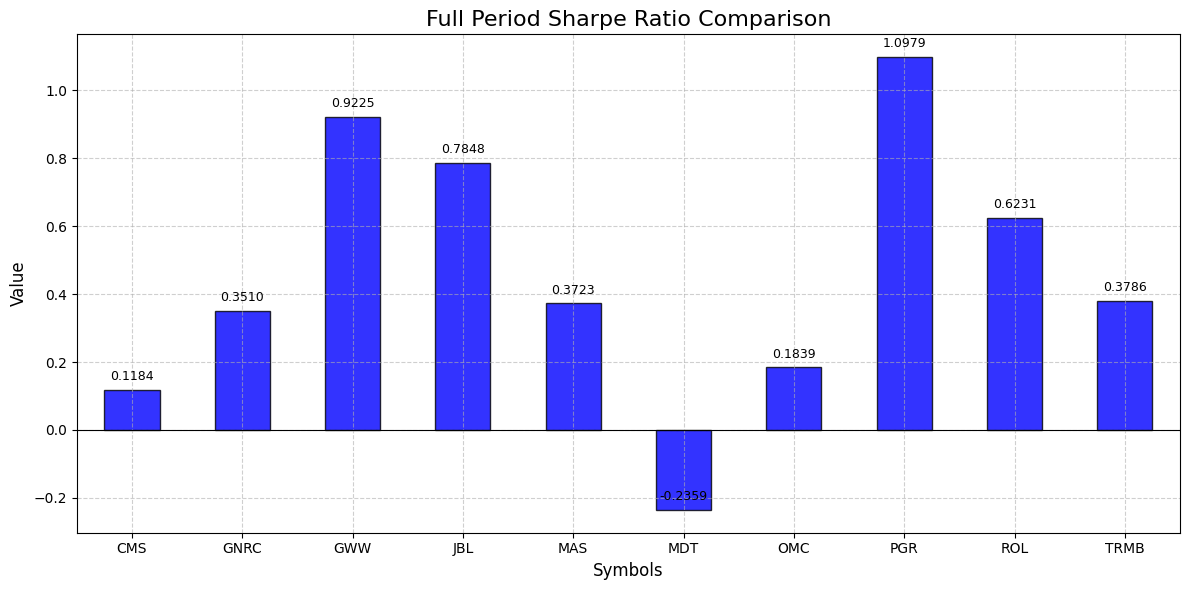

In [1]:
# ==============================================================================
# 📚 1. Standard Library Imports
# ==============================================================================
from datetime import date, datetime
import sys
from typing import List, Set, Tuple

# NEW COMMENT: The 'datetime' library is crucial for financial analysis as it provides the necessary
# temporal framework for handling time-series data. It is used here for:
# 1. Input Validation: Ensuring user dates (S_date, E_date) are valid, correctly formatted, and chronological.
# 2. Data Sourcing: yfinance requires precise date objects for data fetching.
# 3. Time Coefficient Calculation: Used within 'date_checker' and 'interval' modules to determine the
#    annualization coefficient (e.g., 252 for daily, 12 for monthly), which is fundamental for annualizing metrics.

# ==============================================================================
# 📚 2. Third-Party Library Imports
# ==============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display

# ==============================================================================
# 📚 3. Helper Module Imports
# ==============================================================================
try:
    # NEW COMMENT: These external modules handle robust user input and date/interval calculations.
    from input_number_symbols import get_integer_input, get_valid_symbols
    from date_checker import get_min_valid_date, get_valid_date_input
    from interval import set_interval
except ImportError as e:
    print(f"⚠️ Critical Import Error: {e}")
    print(
        "Please ensure 'input_number_symbols.py', 'date_checker.py', and 'interval.py' are in the directory."
    )
    sys.exit()

# ==============================================================================
# ⚙️ 4. Global Constants (Risk-Free Rate)
# ==============================================================================
RISK_FREE_RATE_PERCENT = 4.25  # e.g., 4.25 (Used for user output/Mode 1 calculations)
RISK_FREE_RATE_DECIMAL = 4.25 / 100.0  # e.g., 0.0425 (Used for optimization in Mode 2)


# ==============================================================================
# 🧮 5. Calculation Functions
# ==============================================================================


def calculate_rolling_metrics_optimized(
    df: pd.DataFrame, time_frame: int, time_step: int, coefficient: int
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Calculates rolling Mean, Volatility, and Sharpe Ratio (Script 1 Logic)."""
    if time_frame > len(df):
        raise ValueError("Time frame is larger than the total number of data points.")

    df_simple_returns = df.pct_change() * 100
    df_simple_returns = df_simple_returns.dropna()

    # Calculate rolling mean and standard deviation (volatility) over the specified window.
    df_rolling_mean = df_simple_returns.rolling(window=time_frame).mean()
    df_rolling_vol = df_simple_returns.rolling(window=time_frame).std()

    # Calculate the Risk-Free Rate (Rf) per period, matching the data interval (daily, monthly, etc.).
    # Formula: R_f_period = (1 + R_f_annual)^(1/coefficient) - 1
    Rf_per_period = (1 + RISK_FREE_RATE_PERCENT / 100) ** (1 / coefficient) - 1
    Rf_per_period_perc = Rf_per_period * 100

    # Calculate the Annualized Sharpe Ratio for the rolling window.
    # Formula: Sharpe = (Mean_Return_Period - Rf_Period) / Volatility_Period * sqrt(coefficient)
    # The coefficient annualizes the ratio, where coefficient is 252 for daily data.
    df_rolling_sharpe = (
        (df_rolling_mean - Rf_per_period_perc) / df_rolling_vol * np.sqrt(coefficient)
    )

    # Step the results to only include data at the specified time_step intervals.
    start_index = time_frame - 1
    df_mean_stepped = df_rolling_mean.iloc[start_index::time_step].dropna(how="all")
    df_vol_stepped = df_rolling_vol.iloc[start_index::time_step].dropna(how="all")
    df_sharpe_stepped = df_rolling_sharpe.iloc[start_index::time_step].dropna(how="all")

    return (df_mean_stepped, df_vol_stepped, df_sharpe_stepped)


def calculate_sharpe_ratio(
    weights,
    mean_returns_decimal,
    cov_matrix_decimal,
    risk_free_rate_annual,
    coefficient,
):
    """Calculates the annualized Sharpe Ratio (Script 2 Logic)."""
    # Annualized Portfolio Return (R_p) = sum(weights * mean_period_return) * coefficient
    annual_return = np.sum(mean_returns_decimal * weights) * coefficient

    # Annualized Portfolio Volatility (sigma_p)
    # Volatility = sqrt(w' * Cov * w) * sqrt(coefficient)
    annual_volatility = np.sqrt(
        np.dot(weights.T, np.dot(cov_matrix_decimal, weights))
    ) * np.sqrt(coefficient)

    if annual_volatility == 0:
        return 0.0

    # Sharpe Ratio: S = (R_p - R_f) / sigma_p
    # This ratio measures the excess return (above the risk-free rate) per unit of total risk.
    # Higher values indicate better risk-adjusted performance.
    sharpe_ratio = (annual_return - risk_free_rate_annual) / annual_volatility
    return sharpe_ratio


def negative_sharpe_ratio(
    weights,
    mean_returns_decimal,
    cov_matrix_decimal,
    risk_free_rate_annual,
    coefficient,
):
    """
    Objective function for minimization in Markowitz Optimization (Mode 2).
    Minimizing the negative Sharpe Ratio is mathematically equivalent to maximizing the positive Sharpe Ratio.
    This is because 'minimize' from scipy.optimize always seeks the minimum value.
    """
    if not np.isclose(np.sum(weights), 1.0):
        pass
    sharpe = calculate_sharpe_ratio(
        weights,
        mean_returns_decimal,
        cov_matrix_decimal,
        risk_free_rate_annual,
        coefficient,
    )
    return -sharpe


# ==============================================================================
# 📈 6. Visualization Function
# ==============================================================================


def plot_metrics(
    df: pd.DataFrame,
    title: str,
    is_rolling: bool,
    kind: str = "line",
    time_frame: int = None,
    time_step: int = None,
    value_label: str = None,
):
    try:
        plt.figure(figsize=(12, 6))
        full_title = title
        x_label = "Date"
        color = None

        if is_rolling:
            full_title += f"\n(Window Size: {time_frame}, Step: {time_step})"
            x_label = "End Date of Rolling Window"

        if kind == "bar":
            if "Volatility" in title:
                color = "red"
            elif "Sharpe" in title:
                color = "blue"
            elif "Mean" in title:
                color = "green"

            ax = df.plot(
                kind="bar",
                figsize=(12, 6),
                color=color,
                alpha=0.8,
                edgecolor="black",
                legend=False,
            )
            plt.axhline(0, color="black", linewidth=0.8)
            x_label = "Symbols"
            plt.xticks(rotation=0)

            for p in ax.patches:
                ax.annotate(
                    f"{p.get_height():.4f}",
                    (p.get_x() + p.get_width() / 2.0, p.get_height()),
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    color="black",
                    xytext=(0, 5),
                    textcoords="offset points",
                )
        else:
            plt.plot(df)
            x_label = "Date"

        y_label = value_label if value_label else "Value"

        plt.title(full_title, fontsize=16)
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel(y_label, fontsize=12)

        if kind == "line":
            plt.legend(
                df.columns, title="Symbols", bbox_to_anchor=(1.05, 1), loc="upper left"
            )

        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not generate plot for '{title}'. Error: {e}", file=sys.stderr)


# ==============================================================================
# 🏁 7. Main Execution Block
# ==============================================================================


def execute_analysis():
    print("=========================================")
    print("   🚀 FINANCIAL ANALYSIS TOOLKIT V1.0    ")
    print("=========================================\n")

    # ---------------------------------------------------------
    # PART A: SELECT MODE (Moved to the start)
    # ---------------------------------------------------------
    print("Please select your Analysis Mode:")
    print("[1] Individual Stock Analysis (Rolling Mean, Volatility, Sharpe)")
    print("[2] Portfolio Optimization (Weights, Covariance, Markowitz)")

    mode = input("Enter 1 or 2: ").strip()

    if mode not in ["1", "2"]:
        print("🛑 Invalid mode selection. Exiting.")
        sys.exit()

    # ---------------------------------------------------------
    # PART B: Input Collection & Data Download
    # ---------------------------------------------------------
    print("\n--- Data Configuration ---")
    N_stocks = get_integer_input("Please enter the number of stocks: ")

    # Validation hint for Portfolio Mode
    if mode == "2" and N_stocks < 2:
        print("⚠️ Note: Portfolio optimization typically requires 2 or more stocks.")

    Set_stocks: Set[str] = get_valid_symbols(N_stocks)

    if not Set_stocks:
        print("Execution aborted due to symbol entry error.")
        sys.exit()

    List_stocks: List[str] = list(Set_stocks)
    print(f"\n**Selected Stocks:** {List_stocks}\n")

    # Date Collection
    min_common_date = get_min_valid_date(Set_stocks)
    today_date = date.today()
    S_date = get_valid_date_input(
        f"Enter Start Date (YYYY-MM-DD, min: {min_common_date}): ",
        min_date=min_common_date,
        max_date=today_date,
    )
    # NEW COMMENT: Convert string date input to a datetime.date object for comparison purposes later.
    S_date_dt = datetime.strptime(S_date, "%Y-%m-%d").date()
    E_date = get_valid_date_input(
        f"Enter End Date (YYYY-MM-DD, min: {S_date}): ",
        min_date=S_date_dt,
        max_date=today_date,
    )
    # NEW COMMENT: 'coefficient' is the annualization factor (e.g., 252 for daily trading days, 12 for monthly).
    interval, coefficient = set_interval(S_date, E_date)
    print(f"\n**Data Range:** {S_date} to {E_date}, Interval: {interval}")

    # Data Download
    print("\n⬇️ Downloading data from Yahoo Finance...")
    try:
        data = yf.download(
            List_stocks, start=S_date, end=E_date, interval=interval, auto_adjust=False
        )
        if data.empty:
            raise ValueError("No data returned.")
    except Exception as e:
        print(f"🛑 Error during data download: {e}", file=sys.stderr)
        sys.exit()

    # Extract Adjusted Close
    DF_Adj_Close: pd.DataFrame = data["Adj Close"].copy()
    DF_Adj_Close.dropna(inplace=True)

    if DF_Adj_Close.empty or len(DF_Adj_Close) < 2:
        print("🛑 Insufficient valid data. Aborting.")
        sys.exit()

    # Initial Plot
    display(DF_Adj_Close.head())
    plot_metrics(
        DF_Adj_Close,
        "Adjusted Close Price Time Series",
        is_rolling=False,
        kind="line",
        value_label="Price (Dollars)",
    )

    # ---------------------------------------------------------
    # PART C: Execute Selected Mode Logic
    # ---------------------------------------------------------

    # ==============================================================================
    # MODE 1: Individual Stock Analysis
    # ==============================================================================
    if mode == "1":
        print("\n🔵 STARTING INDIVIDUAL STOCK ANALYSIS")

        DF_simple_return: pd.DataFrame = DF_Adj_Close.pct_change() * 100
        DF_simple_return = DF_simple_return.dropna()

        print("\n📊 Simple Returns (Sample):")
        display(DF_simple_return.head())

        option = (
            str(
                input(
                    "\nDo you want Full-Period results (Y) or Rolling Time Frame (N)? (Y/N): "
                )
            )
            .strip()
            .upper()
        )

        if option == "Y":
            # Full Period
            df_mean_full = DF_simple_return.mean().to_frame("Mean Return")
            df_vol_full = DF_simple_return.std().to_frame("Volatility")

            # Calculate the Risk-Free Rate (Rf) per period, matching the data interval.
            Rf_per_period = (1 + RISK_FREE_RATE_PERCENT / 100) ** (1 / coefficient) - 1
            Rf_per_period_perc = Rf_per_period * 100

            # Calculate the Annualized Sharpe Ratio for the full period.
            # Numerator: (Mean_Return_Period - Rf_Period)
            # Denominator: Volatility_Period
            # Multiplied by sqrt(coefficient) for annualization.
            df_sharpe_full = (
                (df_mean_full["Mean Return"] - Rf_per_period_perc)
                / df_vol_full["Volatility"]
                * np.sqrt(coefficient)
            )
            df_sharpe_full = df_sharpe_full.to_frame("Sharpe Ratio")

            df_results = pd.concat([df_mean_full, df_vol_full, df_sharpe_full], axis=1)
            print("\n📊 Full Period Metrics:")
            display(df_results)

            plot_metrics(DF_simple_return, "Simple Return Time Series", False, "line")
            plot_metrics(df_vol_full, "Full Period Volatility Comparison", False, "bar")
            plot_metrics(
                df_sharpe_full, "Full Period Sharpe Ratio Comparison", False, "bar"
            )

        else:
            # Rolling Period
            print(f"\nGiven your data has **{len(DF_Adj_Close)}** periods.")
            time_frame = get_integer_input("Enter time_frame (window size, e.g., 20): ")
            time_step = get_integer_input(
                "Enter time_step (periods to step, e.g., 5): "
            )

            try:
                (df_mean_roll, df_vol_roll, df_sharpe_roll) = (
                    calculate_rolling_metrics_optimized(
                        DF_Adj_Close, time_frame, time_step, coefficient
                    )
                )
                print("\n💹 Generating plots for rolling metrics...")
                plot_metrics(
                    df_mean_roll,
                    "Rolling Simple Mean Return",
                    True,
                    "line",
                    time_frame,
                    time_step,
                    "Percent per period",
                )
                plot_metrics(
                    df_vol_roll,
                    "Rolling Volatility",
                    True,
                    "line",
                    time_frame,
                    time_step,
                    "Percent per period",
                )
                plot_metrics(
                    df_sharpe_roll,
                    "Rolling Sharpe Ratio",
                    True,
                    "line",
                    time_frame,
                    time_step,
                )

            except ValueError as e:
                print(f"\n🛑 Error in rolling calculation: {e}")
                sys.exit()

    # ==============================================================================
    # MODE 2: Portfolio Analysis
    # ==============================================================================
    elif mode == "2":
        print("\n🟣 STARTING PORTFOLIO OPTIMIZATION")

        # 1. Weights
        option = (
            input(
                "Do you want to enter a custom weight vector? (Y/N, default is N for equal weight): "
            )
            .strip()
            .upper()
        )

        total_amount_input = input(
            f"Enter the total amount to invest (default: 1000 euros): "
        )
        try:
            total_amount = float(total_amount_input)
        except ValueError:
            total_amount = 1000.0
            print(f"Invalid amount entered. Defaulting to {total_amount:.2f} euros.")

        weight = np.zeros(N_stocks)
        if option == "Y":
            print("\n**Entering Custom Weights** (Must be non-negative)")
            for i in range(N_stocks):
                while True:
                    weight_input = input(
                        f"Enter the weight of {List_stocks[i]} (e.g., 0.1): "
                    )
                    try:
                        w = float(weight_input)
                        if w < 0:
                            print("Weight must be non-negative.")
                            continue
                        weight[i] = w
                        break
                    except ValueError:
                        print("Invalid number. Try again.")
        else:
            weight = np.array([1.0 / N_stocks] * N_stocks)
            print("\n**Using Equal Weights.**")

        sum_weight = np.sum(weight)
        if sum_weight == 0:
            print("🛑 Total weight is zero. Aborting.")
            sys.exit()
        # Normalizing weights ensures they sum to 1.0, a fundamental constraint of portfolio theory.
        normal_w = weight / sum_weight
        print(f"Normalized weights: {dict(zip(List_stocks, normal_w))}")

        # 2. Portfolio Calculation
        DF_simple_return: pd.DataFrame = DF_Adj_Close.pct_change() * 100
        DF_simple_return = DF_simple_return.dropna()

        # Calculate the daily return of the portfolio based on the weighted sum of individual returns.
        portfolio_daily_returns_perc: pd.Series = DF_simple_return.dot(normal_w)

        DF_Prt_value_daily = pd.DataFrame(
            index=portfolio_daily_returns_perc.index,
            columns=["The daily value of the portfolio"],
        )
        # Calculate the cumulative value of the portfolio over the investment period.
        current_portfolio_value = total_amount
        for i in portfolio_daily_returns_perc.index:
            current_portfolio_value = current_portfolio_value * (
                1 + portfolio_daily_returns_perc.loc[i] / 100.0
            )
            DF_Prt_value_daily.loc[i] = current_portfolio_value

        print("\n💰 Daily Portfolio Value:")
        display(DF_Prt_value_daily.head())
        plot_metrics(
            DF_Prt_value_daily,
            "Portfolio Value Time Series",
            False,
            "line",
            value_label="Value (Currency)",
        )

        # 3. Metrics
        df_cov = DF_simple_return.cov()
        cov_matrix = df_cov.to_numpy()
        # Convert covariance matrix from (%^2) to (decimal^2) for correct annualization.
        cov_matrix_decimal = cov_matrix / 10000.0

        # Calculate the annualized portfolio volatility using the portfolio variance formula.
        volatility_annual_decimal = np.sqrt(
            np.dot(normal_w.T, np.dot(cov_matrix_decimal, normal_w))
        ) * np.sqrt(coefficient)
        volatility_annual_perc = volatility_annual_decimal * 100.0
        print(
            f"\n✨ Current Annualized Portfolio Volatility: {volatility_annual_perc:.4f}%"
        )

        mean_returns_decimal = DF_simple_return.mean() / 100.0
        portfolio_return_annual_decimal = (
            np.sum(mean_returns_decimal * normal_w) * coefficient
        )

        # Calculate the Sharpe Ratio for the current, non-optimized weights.
        sharpe_ratio_full = (
            portfolio_return_annual_decimal - RISK_FREE_RATE_DECIMAL
        ) / volatility_annual_decimal

        df_sharpe_full = pd.DataFrame(
            {"Portfolio": sharpe_ratio_full}, index=["Sharpe Ratio"]
        ).T
        print("\n⭐ Full Period Portfolio Annualized Sharpe Ratio:")
        display(df_sharpe_full)
        plot_metrics(
            df_sharpe_full,
            "Current Portfolio Sharpe Ratio",
            False,
            "bar",
            value_label="Sharpe Ratio",
        )

        # 4. Optimization
        # NEW COMMENT: This section uses the Sequential Least Squares Programming (SLSQP) method to find
        # the weights that maximize the Sharpe Ratio (i.e., minimize the negative Sharpe Ratio).
        # This portfolio is known as the Tangency Portfolio on the Efficient Frontier.
        print("\n⚙️ Starting Markowitz Optimization (Maximize Sharpe Ratio)...")
        num_assets = len(List_stocks)
        # Bounds ensure weights are between 0 and 1 (no short selling and no leverage).
        bounds = tuple((0, 1) for _ in range(num_assets))
        # Constraint ensures the sum of all weights equals 1 (a fully invested portfolio).
        constraints = {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}
        initial_weights = normal_w

        optimal_results = minimize(
            negative_sharpe_ratio,
            initial_weights,
            args=(
                mean_returns_decimal,
                cov_matrix_decimal,
                RISK_FREE_RATE_DECIMAL,
                coefficient,
            ),
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )

        if optimal_results.success:
            optimal_weights = optimal_results.x
            optimal_sharpe = -optimal_results.fun

            print("\n✅ Optimization Successful!")
            print(f"Optimal Annualized Sharpe Ratio: {optimal_sharpe:.4f}")
            print("\nOptimal Weights (Decimal):")
            optimal_weights_dict = dict(zip(List_stocks, optimal_weights))
            for symbol, weight in optimal_weights_dict.items():
                print(f"  {symbol}: {weight:.4f} ({weight*100:.2f}%)")

            # Calculate metrics for the optimal portfolio weights for comparison.
            optimal_return_annual = (
                np.sum(mean_returns_decimal * optimal_weights) * coefficient
            )
            optimal_volatility_annual = np.sqrt(
                np.dot(optimal_weights.T, np.dot(cov_matrix_decimal, optimal_weights))
            ) * np.sqrt(coefficient)

            print(f"\nOptimal Annualized Return: {optimal_return_annual*100:.4f}%")
            print(
                f"Optimal Annualized Volatility: {optimal_volatility_annual*100:.4f}%"
            )
        else:
            print(f"\n❌ Optimization Failed. Status: {optimal_results.message}")


if __name__ == "__main__":
    execute_analysis()